In [2]:
%matplotlib inline


# Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation


This is an example of applying :class:`sklearn.decomposition.NMF` and
:class:`sklearn.decomposition.LatentDirichletAllocation` on a corpus
of documents and extract additive models of the topic structure of the
corpus.  The output is a list of topics, each represented as a list of
terms (weights are not shown).

Non-negative Matrix Factorization is applied with two different objective
functions: the Frobenius norm, and the generalized Kullback-Leibler divergence.
The latter is equivalent to Probabilistic Latent Semantic Indexing.

The default parameters (n_samples / n_features / n_components) should make
the example runnable in a couple of tens of seconds. You can try to
increase the dimensions of the problem, but be aware that the time
complexity is polynomial in NMF. In LDA, the time complexity is
proportional to (n_samples * iterations).




In [3]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

from __future__ import print_function

import itertools
from pathlib import Path
from time import time
import os

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

from text_processing.simple import parse

n_samples = 5000
n_features = 5000
n_components = 15
n_top_words = 20


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


print("Loading dataset...")
t0 = time()
data_samples = [parse(f) for f in itertools.islice(Path("./out/docs_simple2").rglob("*.html"), n_samples)]
print("done in %0.3fs." % (time() - t0))

Loading dataset...
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART


/usr/lib/python3/dist-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART

NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART
NO MAIN PART

In [3]:
from collections import defaultdict

from nltk.stem.snowball import SnowballStemmer


class key_dependent_dict(defaultdict):
    def __init__(self,f_of_x):
        super().__init__(None) # base class doesn't get a factory
        self.f_of_x = f_of_x # save f(x)
    def __missing__(self, key): # called when a default needed
        ret = self.f_of_x(key) # calculate default value
        self[key] = ret # and install it in the dict
        return ret


STOP_WORDS = {'от', 'на', 'не', 'рф', 'ст'}

stemmer = SnowballStemmer("russian")
CACHE = key_dependent_dict(lambda w: stemmer.stem(w))


In [5]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([CACHE[w] for w in analyzer(doc) if w not in STOP_WORDS])


class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: ([CACHE[w] for w in analyzer(doc) if w not in STOP_WORDS])


# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = StemmedTfidfVectorizer(max_df=0.9, min_df=2,
                                   max_features=n_features,
                                   stop_words=None)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = StemmedCountVectorizer(max_df=0.9, min_df=2,
                                max_features=n_features,
                                stop_words=None)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

# Fit the NMF model
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Extracting tf-idf features for NMF...
done in 14.790s.
Extracting tf features for LDA...
done in 10.938s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=5000 and n_features=5000...
done in 16.480s.

Topics in NMF model (Frobenius norm):
Topic #0: товар покупател поставк договор ответчик поставщик оплат sum 2017 требован ил соответств накладн поставлен сумм истц товарн обязательств сторон продукц
Topic #1: энерг электрическ теплов потреблен оплат потребител абонент мощност договор ответчик организац сет энергоснабжен электроэнерг фактическ теплоснабжен 2017 прибор соответств теплоносител
Topic #2: арендн аренд плат договор арендатор арендодател ответчик имуществ пользован внесен помещен 2017 платеж 01 требован соответств sum задолжен услов размер
Topic #3: страхов транспортн возмещен страховщик страхован выплат потерпевш вред экспертиз поврежден расход средств осаг причинен автомобил дтп прав обязательн ремонт восстановительн
Topic #4: приказ 229 взыскател выдач

In [6]:
from gensim import corpora, models, similarities

analyzer = TfidfVectorizer().build_analyzer()
texts = [[CACHE[w] for w in analyzer(doc) if w not in STOP_WORDS] for doc in data_samples]
dictionary = corpora.Dictionary(texts)


In [7]:
dictionary.filter_extremes(no_below=10)
print(len(dictionary))

6793


In [8]:
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [9]:
from gensim import matutils
import numpy as np

numpy_matrix = matutils.corpus2dense(corpus_tfidf, num_terms=len(dictionary))
s = np.linalg.svd(numpy_matrix, full_matrices=False, compute_uv=False)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:503: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.column_stack(sparse2full(doc, num_terms) for doc in corpus)


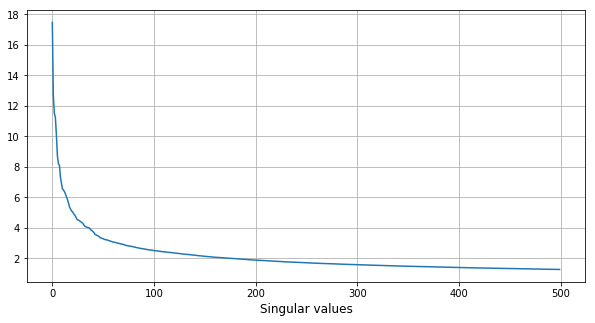

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(s[:500])
plt.xlabel('Singular values', fontsize=12)
plt.grid(True, 'both')
plt.show()

In [11]:
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=100)
index = similarities.MatrixSimilarity(lsi[corpus_tfidf]) # transform corpus to LSI space and index it

In [15]:
print(data_samples[4])
doc = corpus_tfidf[4]
vec_lsi = lsi[doc] # convert the vector to LSI space
sims = index[vec_lsi] # perform a similarity vector against the corpus
most_similar = np.argsort(sims)[1:]
print(most_similar[1])
print(data_samples[most_similar[1]])

Истец - Индивидуальный предприниматель  Карпушина Лариса Юрьевна обратилось в Арбитражный суд города Санкт-Петербурга и Ленинградской области о взыскании с ответчика – общества с ограниченной ответственностью «ПИОНЕР-СЕРВИС СЕВЕР» 825.SUM ущерба, причиненного 01.04.2018г. заливом нежилого помещения по адресу: Санкт-Петербург, Приморский пр., д. 52, к.1, лит. А, пом. 18-Н.(далее по тексту – нежилое помещение). 
Определением от 06.07.2018 стороны были извещены, что при наличии условий, указанных в п. 1 ст. 137 АПК РФ, и отсутствии возражений лиц, участвующих в деле, 23.08.2018 подготовка дела к судебному разбирательству будет завершена, и дело будет рассмотрено в судебном заседании арбитражного суда первой инстанции. Возражений не поступило, суд признал дело подготовленным, определил завершить подготовку дела к судебному разбирательству, и рассмотрел дело в судебном заседании арбитражного суда первой инстанции.
Надлежащим образом извещенный по всем представленным в арбитражный суд адреса